In [12]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem
import pandas as pd
import numpy as np
import copy
output_path = "./output/optimization/"

In [13]:
samples_temp = []
orientation_values = [0,90,180,270] 
wwr_values = [.05,.15, .5] # to calculate the u-value
tickness_values = np.linspace(0.001,0.35,10) 
for ori in orientation_values:
    for wwr_ in wwr_values:
        for tickness in tickness_values:
            samples_temp.append({'Orientation': ori,
                                 'Window to Wall Ratio': wwr_,
                                 'Insulation Thickness': tickness,})
samples = pd.DataFrame.from_dict(samples_temp)
samples


,Orientation,Window to Wall Ratio,Insulation Thickness
0,0,0.05,0.001000
1,0,0.05,0.039778
2,0,0.05,0.078556
3,0,0.05,0.117333
4,0,0.05,0.156111
...,...,...,...
115,270,0.50,0.194889
116,270,0.50,0.233667
117,270,0.50,0.272444
118,270,0.50,0.311222


In [14]:
files= ['on_single.idf','on_double.idf', 'on_triple.idf','off_single.idf','off_double.idf', 'off_triple.idf']
results = pd.core.frame.DataFrame()
for item in files:

    building = ef.get_building(building='./input/'+item, 
                 output_directory=output_path,
                 mode='idf')
    insulation = FieldSelector(class_name='Material', object_name='MW Glass Wool (rolls)_O.1445', field_name='Thickness')
    insulationPR = Parameter(selector=insulation, value_descriptor=RangeParameter(0.0001, 0.35),
                             name='Insulation Thickness')


    window_to_wall = wwr(CategoryParameter(options=[0.05, 0.15, 0.5]))
    #window_to_wall = wwr(RangeParameter(0.05, 0.15, 0.5))

    orientation = FieldSelector(class_name='Building', field_name='North Axis')
    orientationPR = Parameter(selector=orientation, value_descriptor=CategoryParameter(options=[0, 90, 180, 270]),
                              name='Orientation')

    parameters = [orientationPR , window_to_wall, insulationPR]

    objectives = ['Electricity:Facility', 'DistrictHeating:Facility', 'DistrictCooling:Facility']

    #problem = EPProblem(parameters, objectives)
    problem = EPProblem(inputs=parameters, outputs=objectives)
    evaluator = EvaluatorEP(problem, building,epw= "./input/ITA_Torino_160590_IWEC.epw", 
                            out_dir=output_path, error_mode='Silent', err_dir=output_path)          
    
    outputs = evaluator.df_apply(samples, keep_input=True)    
    if item.split('_')[0] == 'on':
        outputs['Ventilation'] = 'on'
    else:
        outputs['Ventilation'] = 'off'
    
    if item.split('_')[1] == 'single.idf':
        outputs['Glazing'] = 'single'
    elif item.split('_')[1] == 'double.idf':
        outputs['Glazing'] = 'double'
    else :
        outputs['Glazing'] = 'triple'
        
    
    results = results.append(outputs)
    print(str(item) + ' is finished')    


/home/ict4bd_v2/py3/lib/python3.8/site-packages/besos-1.7.0-py3.8.egg/besos/parameters.py:592: UserWarning: wwr is intended to be used with RangeParameter. Your value_descriptor is CategoryParameter(options=[0.05, 0.15, 0.5])
  warnings.warn(



on_single.idf is finished



on_double.idf is finished



on_triple.idf is finished



off_single.idf is finished



off_double.idf is finished



off_triple.idf is finished


In [15]:
run_results=results

In [16]:
print(results)

     Orientation  Window to Wall Ratio  Insulation Thickness  \
0              0                  0.05              0.001000   
1              0                  0.05              0.039778   
2              0                  0.05              0.078556   
3              0                  0.05              0.117333   
4              0                  0.05              0.156111   
..           ...                   ...                   ...   
115          270                  0.50              0.194889   
116          270                  0.50              0.233667   
117          270                  0.50              0.272444   
118          270                  0.50              0.311222   
119          270                  0.50              0.350000   

     Electricity:Facility  DistrictHeating:Facility  DistrictCooling:Facility  \
0            1.806100e+11              3.899633e+11              1.666910e+11   
1            1.806100e+11              2.125081e+11              6.55

In [17]:
Zones = building.model.dt['Zone'.upper()] # geting info of each zone
df = pd.DataFrame(Zones) 
total_area = df[10].sum() # total floor area 
total_area
#results

1030.892

In [18]:
results['Electricity:Facility'] /= 3.6e6
results['DistrictHeating:Facility'] /= 3.6e6
results['DistrictCooling:Facility'] /= 3.6e6
results['TotalConsumption'] = results['DistrictHeating:Facility'] + results['DistrictCooling:Facility']
results

,Orientation,Window to Wall Ratio,Insulation Thickness,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Ventilation,Glazing,TotalConsumption
0,0,0.05,0.001000,50169.434376,108323.132367,46303.044775,on,single,154626.177141
1,0,0.05,0.039778,50169.434376,59030.032799,18219.080945,on,single,77249.113744
2,0,0.05,0.078556,50169.434376,48541.771605,13011.095156,on,single,61552.866760
3,0,0.05,0.117333,50169.434376,44032.125133,10785.094941,on,single,54817.220074
4,0,0.05,0.156111,50169.434376,41521.766489,9604.148762,on,single,51125.915251
...,...,...,...,...,...,...,...,...,...
115,270,0.50,0.194889,50169.434376,40534.073663,13382.980630,off,triple,53917.054293
116,270,0.50,0.233667,50169.434376,39390.801289,12798.423529,off,triple,52189.224819
117,270,0.50,0.272444,50169.434376,38562.102252,12363.132316,off,triple,50925.234567
118,270,0.50,0.311222,50169.434376,37936.510484,12021.633869,off,triple,49958.144353


In [19]:
results = results.reset_index()
results

,index,Orientation,Window to Wall Ratio,Insulation Thickness,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Ventilation,Glazing,TotalConsumption
0,0,0,0.05,0.001000,50169.434376,108323.132367,46303.044775,on,single,154626.177141
1,1,0,0.05,0.039778,50169.434376,59030.032799,18219.080945,on,single,77249.113744
2,2,0,0.05,0.078556,50169.434376,48541.771605,13011.095156,on,single,61552.866760
3,3,0,0.05,0.117333,50169.434376,44032.125133,10785.094941,on,single,54817.220074
4,4,0,0.05,0.156111,50169.434376,41521.766489,9604.148762,on,single,51125.915251
...,...,...,...,...,...,...,...,...,...,...
715,115,270,0.50,0.194889,50169.434376,40534.073663,13382.980630,off,triple,53917.054293
716,116,270,0.50,0.233667,50169.434376,39390.801289,12798.423529,off,triple,52189.224819
717,117,270,0.50,0.272444,50169.434376,38562.102252,12363.132316,off,triple,50925.234567
718,118,270,0.50,0.311222,50169.434376,37936.510484,12021.633869,off,triple,49958.144353


In [20]:
results['Electricity:Facility'] /= total_area
results['DistrictHeating:Facility'] /= total_area
results['DistrictCooling:Facility'] /= total_area
results['TotalConsumption'] /= total_area
results

,index,Orientation,Window to Wall Ratio,Insulation Thickness,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Ventilation,Glazing,TotalConsumption
0,0,0,0.05,0.001000,48.666043,105.077091,44.915515,on,single,149.992606
1,1,0,0.05,0.039778,48.666043,57.261122,17.673123,on,single,74.934245
2,2,0,0.05,0.078556,48.666043,47.087155,12.621201,on,single,59.708356
3,3,0,0.05,0.117333,48.666043,42.712646,10.461906,on,single,53.174552
4,4,0,0.05,0.156111,48.666043,40.277514,9.316348,on,single,49.593862
...,...,...,...,...,...,...,...,...,...,...
715,115,270,0.50,0.194889,48.666043,39.319418,12.981942,off,triple,52.301361
716,116,270,0.50,0.233667,48.666043,38.210405,12.414902,off,triple,50.625308
717,117,270,0.50,0.272444,48.666043,37.406539,11.992655,off,triple,49.399195
718,118,270,0.50,0.311222,48.666043,36.799694,11.661390,off,triple,48.461085


In [21]:
#
results['Electricity:Facility'] = results['Electricity:Facility'].apply(lambda x: round(x, 2))
results['DistrictHeating:Facility'] = results['DistrictHeating:Facility'].apply(lambda x: round(x, 2))
results['DistrictCooling:Facility'] = results['DistrictCooling:Facility'].apply(lambda x: round(x, 2))
results['TotalConsumption'] = results['TotalConsumption'].apply(lambda x: round(x, 2))
results

,index,Orientation,Window to Wall Ratio,Insulation Thickness,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Ventilation,Glazing,TotalConsumption
0,0,0,0.05,0.001000,48.67,105.08,44.92,on,single,149.99
1,1,0,0.05,0.039778,48.67,57.26,17.67,on,single,74.93
2,2,0,0.05,0.078556,48.67,47.09,12.62,on,single,59.71
3,3,0,0.05,0.117333,48.67,42.71,10.46,on,single,53.17
4,4,0,0.05,0.156111,48.67,40.28,9.32,on,single,49.59
...,...,...,...,...,...,...,...,...,...,...
715,115,270,0.50,0.194889,48.67,39.32,12.98,off,triple,52.30
716,116,270,0.50,0.233667,48.67,38.21,12.41,off,triple,50.63
717,117,270,0.50,0.272444,48.67,37.41,11.99,off,triple,49.40
718,118,270,0.50,0.311222,48.67,36.80,11.66,off,triple,48.46


In [22]:
samples_for_plot = copy.deepcopy(results)
samples_for_plot = samples_for_plot.drop(columns=['DistrictHeating:Facility', 'DistrictCooling:Facility','TotalConsumption','Electricity:Facility','index'])
samples_for_plot

,Orientation,Window to Wall Ratio,Insulation Thickness,Ventilation,Glazing
0,0,0.05,0.001000,on,single
1,0,0.05,0.039778,on,single
2,0,0.05,0.078556,on,single
3,0,0.05,0.117333,on,single
4,0,0.05,0.156111,on,single
...,...,...,...,...,...
715,270,0.50,0.194889,off,triple
716,270,0.50,0.233667,off,triple
717,270,0.50,0.272444,off,triple
718,270,0.50,0.311222,off,triple


In [23]:
results

,index,Orientation,Window to Wall Ratio,Insulation Thickness,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Ventilation,Glazing,TotalConsumption
0,0,0,0.05,0.001000,48.67,105.08,44.92,on,single,149.99
1,1,0,0.05,0.039778,48.67,57.26,17.67,on,single,74.93
2,2,0,0.05,0.078556,48.67,47.09,12.62,on,single,59.71
3,3,0,0.05,0.117333,48.67,42.71,10.46,on,single,53.17
4,4,0,0.05,0.156111,48.67,40.28,9.32,on,single,49.59
...,...,...,...,...,...,...,...,...,...,...
715,115,270,0.50,0.194889,48.67,39.32,12.98,off,triple,52.30
716,116,270,0.50,0.233667,48.67,38.21,12.41,off,triple,50.63
717,117,270,0.50,0.272444,48.67,37.41,11.99,off,triple,49.40
718,118,270,0.50,0.311222,48.67,36.80,11.66,off,triple,48.46


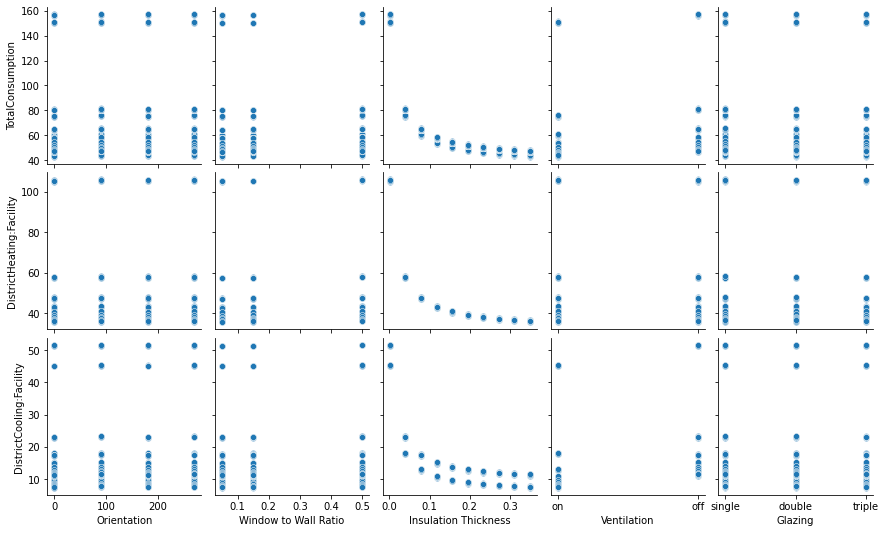

In [24]:
objectives = ['TotalConsumption', 'DistrictHeating:Facility', 'DistrictCooling:Facility']
_ = pairplot(results, x_vars=samples_for_plot.columns, y_vars=objectives, kind="scatter", diag_kind=None)

Text(0, 0.5, 'DistrictCooling:Facility')

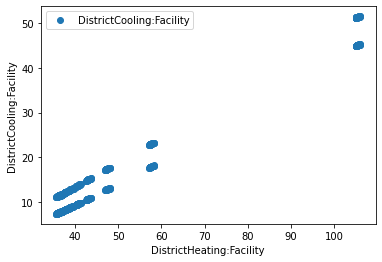

In [25]:
_ = results.plot(x=objectives[1], y=objectives[2], style='o')
plt.xlabel(objectives[1])
plt.ylabel(objectives[2])

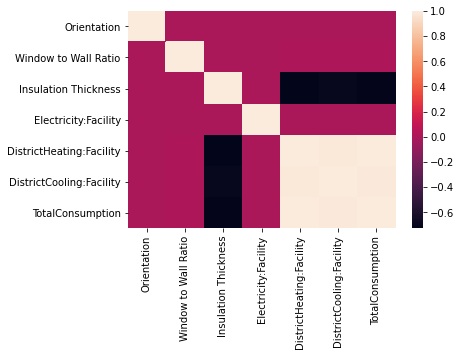

In [26]:
A=results.drop(columns=['index'])
_ = heatmap(A.corr())